# Pathway analysis

## Overview

**Reactome Pathway Enrichment**

`get_reactome_raw(gene_list)` — Performs Reactome pathway analysis on a gene set and returns the complete raw output as a DataFrame. Includes all pathway metadata (IDs, names, p-values, entity counts, reaction ratios).

`get_reactome(gene_list, p_type)` — Wrapper around `get_reactome_raw` that returns a cleaned DataFrame with pathway names, Reactome IDs, p-values (or FDR), and -log10 transformed values.

```python
path = get_reactome(
    gene_list=pi3ks,   # list of gene symbols to analyze
    p_type='FDR',      # 'FDR' or 'p' for raw p-value
)
```

---

**Reference Database Queries**

`query_reactome(uniprot_id)` — Queries a UniProt ID against the Reactome pathway database. Returns all pathways (at any hierarchy level) that the protein participates in, with a `lowest` flag indicating leaf-level pathways.

`add_reactome_ref(df, uniprot)` — Augments a pathway analysis DataFrame with reference columns indicating whether each pathway is annotated for a specific protein. Also appends any missing pathways from the reference (with p=1.0).

```python
out = add_reactome_ref(
    df=path,           # output DataFrame from get_reactome()
    uniprot='P31749',  # UniProt ID of kinase to check against
)
# Adds columns: ref_path (1/0), ref_path_lowest (1/0)
```

---

**Visualization**

`plot_path(react_df, ...)` — Creates a horizontal bar plot of top enriched pathways. Optionally highlights bars in dark red for pathways matching a reference set.

```python
plot_path(
    react_df=out,                # pathway DataFrame with -log10 p-values
    p_type='FDR',                # 'FDR' or 'p' - which p-value column to plot
    ref_col='ref_path',          # column name (1/0) to highlight matching bars
    ref_id_list=None,            # alternative: list of reactome_ids to highlight
    top_n=15,                    # number of top pathways to display
    max_label_length=80,         # truncate pathway names longer than this
)
```

---

**Overlap Statistics**

`get_overlap(react_df, ...)` — Calculates what fraction of reference pathways pass a significance threshold. Optionally plots a histogram of -log10(p) values with a threshold line.

```python
accuracy = get_overlap(
    react_df=out,                # pathway DataFrame from add_reactome_ref()
    ref_col='ref_path_lowest',   # column name (1/0) indicating reference pathways
    ref_id_list=None,            # alternative: list of reactome_ids
    p_type='FDR',                # 'FDR' or 'p'
    thr=0.05,                    # significance threshold (before log transform)
    plot=True,                   # whether to show histogram
    figsize=(5, 3),              # figure size tuple
)
# Returns: float (fraction passing threshold, e.g., 0.97)
```

---

**Complete Pipeline Example**

```python
# 1. Run pathway enrichment on gene set
out = get_reactome(
    gene_list=pi3ks,   # list of gene symbols
    p_type='FDR',      # use FDR-corrected p-values
)

# 2. Add reference annotations for a specific kinase
out = add_reactome_ref(
    df=out,            # enrichment results
    uniprot='P31749',  # AKT1 UniProt ID
)

# 3. Visualize top pathways with reference highlighting
plot_path(
    react_df=out,              # augmented DataFrame
    p_type='FDR',              # plot -log10(FDR)
    ref_col='ref_path_lowest', # highlight lowest-level reference pathways
    top_n=15,                  # show top 15
)

# 4. Calculate overlap accuracy
accuracy = get_overlap(
    react_df=out,              # augmented DataFrame
    ref_col='ref_path_lowest', # evaluate against lowest-level pathways
    thr=0.05,                  # FDR < 0.05 significance cutoff
    plot=True,                 # show histogram
)
```

## Setup

In [ ]:
#| default_exp pathway

In [ ]:
#| export
# reactome, pip install reactome2py
from pandas import json_normalize
from reactome2py import analysis
from matplotlib import pyplot as plt
import numpy as np, pandas as pd
from katlas.data import *

## Reactome pathway

In [ ]:
#| export
def get_reactome_raw(gene_list):
    "Reactome pathway analysis for a given gene set; returns raw output in dataframe."
    gene_str = ','.join(gene_list)
    # set page size and page to -1 ensures to display all pathway results, sort by pvalue instead of fdr, projection set to True is consistent with official web
    result = analysis.identifiers(gene_str, page_size='-1', page='-1', sort_by='ENTITIES_FDR',projection=True)
    return json_normalize(result['pathways'])

In [ ]:
pi3ks=['PIK3CA','PIK3CB','PIK3CD','PIK3CG','PIK3R1','PIK3R2','PIK3R3','PTEN','AKT1','AKT2','AKT3','MTOR','RICTOR','RPTOR','TSC1','TSC2','PDK1','IRS1','IRS2','INSR','IGF1R','GAB1','HRAS','NRAS','KRAS','EGFR','ERBB2','ERBB3','ERBB4']

In [ ]:
raw_out = get_reactome_raw(pi3ks)
raw_out.head()

,stId,dbId,name,llp,inDisease,species.dbId,species.taxId,species.name,entities.resource,entities.total,entities.found,entities.ratio,entities.pValue,entities.fdr,entities.exp,reactions.resource,reactions.total,reactions.found,reactions.ratio
0,R-HSA-1963640,1963640,GRB2 events in ERBB2 signaling,True,False,48887,9606,Homo sapiens,TOTAL,21,9,0.001304,1.110223e-16,1.221245e-15,[],TOTAL,4,4,0.000255
1,R-HSA-9665348,9665348,Signaling by ERBB2 ECD mutants,True,True,48887,9606,Homo sapiens,TOTAL,23,9,0.001428,1.110223e-16,1.221245e-15,[],TOTAL,15,15,0.000957
2,R-HSA-9664565,9664565,Signaling by ERBB2 KD Mutants,True,True,48887,9606,Homo sapiens,TOTAL,35,13,0.002174,1.110223e-16,1.221245e-15,[],TOTAL,17,17,0.001085
3,R-HSA-1227990,1227990,Signaling by ERBB2 in Cancer,False,True,48887,9606,Homo sapiens,TOTAL,36,13,0.002236,1.110223e-16,1.221245e-15,[],TOTAL,62,62,0.003957
4,R-HSA-9665686,9665686,Signaling by ERBB2 TMD/JMD mutants,True,True,48887,9606,Homo sapiens,TOTAL,30,10,0.001863,1.110223e-16,1.221245e-15,[],TOTAL,13,13,0.000830


In [ ]:
#| export
def get_reactome(gene_list,
                 p_type='FDR', # or p
                ):
    "Reactome pathway analysis for a given gene set; returns formated output in dataframe with additional -log10(p)"
    if p_type not in ['p','FDR']: raise ValueError("p_type must be either 'p' or 'FDR'")
    col='entities.pValue' if p_type=='p' else 'entities.fdr'
    print('Running pathway anlysis')
    out = get_reactome_raw(gene_list)
    print('Done')
    out = out[['name','stId',col]].rename(columns={col:p_type,'stId':'reactome_id'})
    out[f'-log10_{p_type}'] = -np.log10(out[p_type]).round(3)
    return out

In [ ]:
path = get_reactome(pi3ks,p_type='p')
path.head()

Running pathway anlysis
Done


,name,reactome_id,p,-log10_p
0,GRB2 events in ERBB2 signaling,R-HSA-1963640,1.110223e-16,15.955
1,Signaling by ERBB2 ECD mutants,R-HSA-9665348,1.110223e-16,15.955
2,Signaling by ERBB2 KD Mutants,R-HSA-9664565,1.110223e-16,15.955
3,Signaling by ERBB2 in Cancer,R-HSA-1227990,1.110223e-16,15.955
4,Signaling by ERBB2 TMD/JMD mutants,R-HSA-9665686,1.110223e-16,15.955


In [ ]:
path = get_reactome(pi3ks,p_type='FDR')
path.head()

Running pathway anlysis
Done


,name,reactome_id,FDR,-log10_FDR
0,GRB2 events in ERBB2 signaling,R-HSA-1963640,1.221245e-15,14.913
1,Signaling by ERBB2 ECD mutants,R-HSA-9665348,1.221245e-15,14.913
2,Signaling by ERBB2 KD Mutants,R-HSA-9664565,1.221245e-15,14.913
3,Signaling by ERBB2 in Cancer,R-HSA-1227990,1.221245e-15,14.913
4,Signaling by ERBB2 TMD/JMD mutants,R-HSA-9665686,1.221245e-15,14.913


In [ ]:
path[path.FDR<0.05]

,name,reactome_id,FDR,-log10_FDR
0,GRB2 events in ERBB2 signaling,R-HSA-1963640,1.221245e-15,14.913
1,Signaling by ERBB2 ECD mutants,R-HSA-9665348,1.221245e-15,14.913
2,Signaling by ERBB2 KD Mutants,R-HSA-9664565,1.221245e-15,14.913
3,Signaling by ERBB2 in Cancer,R-HSA-1227990,1.221245e-15,14.913
4,Signaling by ERBB2 TMD/JMD mutants,R-HSA-9665686,1.221245e-15,14.913
...,...,...,...,...
319,Viral Infection Pathways,R-HSA-9824446,3.888317e-02,1.410
320,RHO GTPase cycle,R-HSA-9012999,3.922694e-02,1.406
321,RUNX3 regulates p14-ARF,R-HSA-8951936,4.374857e-02,1.359
322,Cellular response to chemical stress,R-HSA-9711123,4.654844e-02,1.332


## Reference

Download from Reactome/Download_data: https://reactome.org/download-data

Download `UniProt to All pathways` under `Identifier mapping files`

for type, there are IEA (Inferred from Electronic Annotation) and TAS (Traceable Author Statement, higher confidence)

In [ ]:
ref = Data.get_reactome_pathway()

In [ ]:
ref.head()

,uniprot,reactome_id,pathway,type,species
0,A0A023GPK8,R-DME-1500931,Cell-Cell communication,IEA,Drosophila melanogaster
1,A0A023GPK8,R-DME-373753,Nephrin family interactions,IEA,Drosophila melanogaster
2,A0A023GRW3,R-DME-72163,mRNA Splicing - Major Pathway,IEA,Drosophila melanogaster
3,A0A023GRW3,R-DME-72172,mRNA Splicing,IEA,Drosophila melanogaster
4,A0A023GRW3,R-DME-72203,Processing of Capped Intron-Containing Pre-mRNA,IEA,Drosophila melanogaster


In [ ]:
#| export
def query_reactome(uniprot_id):
    """Query uniprot ID in Reactome all level pathway database."""

    ref = Data.get_reactome_pathway()
    ref_lo = Data.get_reactome_pathway_lo()
    
    # Filter specific uniprot
    uniprot_ref = ref[ref.uniprot == uniprot_id].copy()
    uniprot_ref_lo = ref_lo[ref_lo.uniprot == uniprot_id].copy()

    # Group by reactome_id and aggregate other columns
    grouped = uniprot_ref.groupby("reactome_id", as_index=False).agg({
        "uniprot": "first",
        "pathway": "first",
        "type": lambda x: ", ".join(sorted(set(x))), # multiple type
        "species": "first",
    })
    grouped['lowest'] =grouped.reactome_id.isin(uniprot_ref_lo.reactome_id).astype(int)
    return grouped.reset_index(drop=True)

In [ ]:
uniprot='P31751' # AKT2
akt_path = query_reactome(uniprot) # AKT2

In [ ]:
akt_path

,reactome_id,uniprot,pathway,type,species,lowest
0,R-HSA-109581,P31751,Apoptosis,IEA,Homo sapiens,0
1,R-HSA-109606,P31751,Intrinsic Pathway for Apoptosis,IEA,Homo sapiens,0
2,R-HSA-109703,P31751,PKB-mediated events,IEA,Homo sapiens,0
3,R-HSA-109704,P31751,PI3K Cascade,"IEA, TAS",Homo sapiens,0
4,R-HSA-111447,P31751,Activation of BAD and translocation to mitocho...,IEA,Homo sapiens,1
...,...,...,...,...,...,...
93,R-HSA-9755511,P31751,KEAP1-NFE2L2 pathway,TAS,Homo sapiens,1
94,R-HSA-9755779,P31751,SARS-CoV-2 targets host intracellular signalli...,TAS,Homo sapiens,1
95,R-HSA-9824446,P31751,Viral Infection Pathways,TAS,Homo sapiens,0
96,R-HSA-9824585,P31751,Regulation of MITF-M-dependent genes involved ...,IEA,Homo sapiens,1


In [ ]:
# lowest
akt_path[akt_path.lowest==1].shape

(32, 6)

In [ ]:
#| export
def add_reactome_ref(df,uniprot):
    path = query_reactome(uniprot)
    df = df.copy()
    df['ref_path'] = df.reactome_id.isin(path.reactome_id).astype(int)
    df['ref_path_lowest'] = df.reactome_id.isin(path[path["lowest"] == 1].reactome_id).astype(int)

    # find missing reactome_ids
    missing = path.loc[~path.reactome_id.isin(df.reactome_id), ['reactome_id', 'pathway', 'lowest']]
    if not missing.empty:
        add_df = pd.DataFrame({
            'name': missing['pathway'],
            'reactome_id': missing['reactome_id'],
            'ref_path': 1,
            'ref_path_lowest': (missing['lowest'] == 1).astype(int),
            df.columns[2]: 1.0,         # assign 1.0 to p value column
            df.columns[3]: 0,      # assign 0 to log10 p column
        })
        df = pd.concat([df, add_df], ignore_index=True)
    return df

In [ ]:
out = add_reactome_ref(path,uniprot)
out.shape

(403, 6)

## Bar plot of pathways

In [ ]:
#| export
def plot_path(react_df, # the output df of get_reactome
              p_type='FDR', 
              ref_id_list=None, # list of reactome_id
              ref_col = None, # column in reac_df, 1 or 0 to indicate whether it's in ref
              top_n=10, 
              max_label_length=80 ):
    """
    Plot the output of get_reactome.
    If ref_df is provided, bars corresponding to pathways in ref_df are shown in dark red.
    """
    if p_type not in ['p','FDR']: raise ValueError("p_type must be either 'p' or 'FDR'")
    p_col=f'-log10_{p_type}'
    # Take top_n rows
    subset = react_df.head(top_n)

    # Determine bar colors: if ref_df is provided, highlight matching pathways
    if ref_id_list is not None:
        ref_ids = set(ref_id_list)
        colors = ['darkred' if rid in ref_ids else 'C0' for rid in subset['reactome_id']]
    elif ref_col is not None:
        ref_ids = set(react_df[react_df[ref_col]==1].reactome_id)
        colors = ['darkred' if rid in ref_ids else 'C0' for rid in subset['reactome_id']]
    else:
        colors = 'C0'

    # Reverse order for horizontal bar plot
    data = subset.set_index('name')[p_col].iloc[::-1]
    # If colors is a list, reverse it to match the data order
    if isinstance(colors, list):
        colors = list(reversed(colors))

    # Truncate labels if too long
    truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in data.index]
    data.index = truncated_labels

    # Calculate figure width based on label length
    base_width = 2
    max_label = max(data.index, key=len)
    additional_width = len(max_label) * 0.1  # adjust scaling factor as needed
    figsize = (base_width + additional_width, 3 * top_n / 10)

    data.plot.barh(figsize=figsize, color=colors)
    plt.ylabel('')
    plt.xlabel(p_col.replace('_', '(', 1) + ')')
    plt.tight_layout()

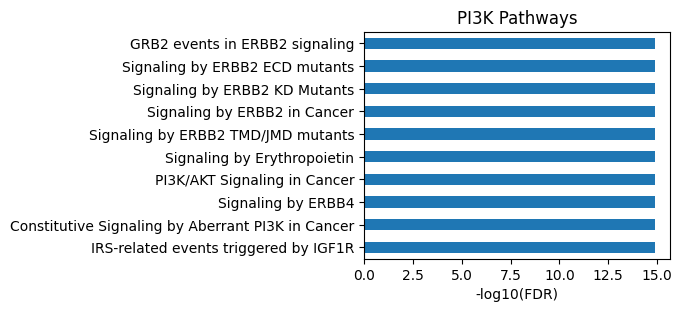

In [ ]:
plot_path(out)
plt.title('PI3K Pathways');

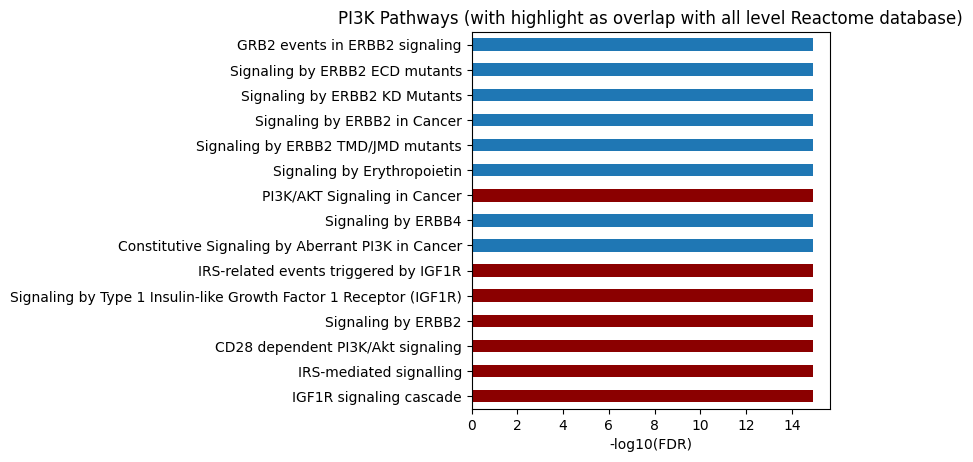

In [ ]:
# All level
plot_path(out,p_type='FDR',ref_id_list=akt_path.reactome_id,top_n=15)
plt.title('PI3K Pathways (with highlight as overlap with all level Reactome database)');

In [ ]:
out.head()

,name,reactome_id,FDR,-log10_FDR,ref_path,ref_path_lowest
0,GRB2 events in ERBB2 signaling,R-HSA-1963640,1.221245e-15,14.913,0,0
1,Signaling by ERBB2 ECD mutants,R-HSA-9665348,1.221245e-15,14.913,0,0
2,Signaling by ERBB2 KD Mutants,R-HSA-9664565,1.221245e-15,14.913,0,0
3,Signaling by ERBB2 in Cancer,R-HSA-1227990,1.221245e-15,14.913,0,0
4,Signaling by ERBB2 TMD/JMD mutants,R-HSA-9665686,1.221245e-15,14.913,0,0


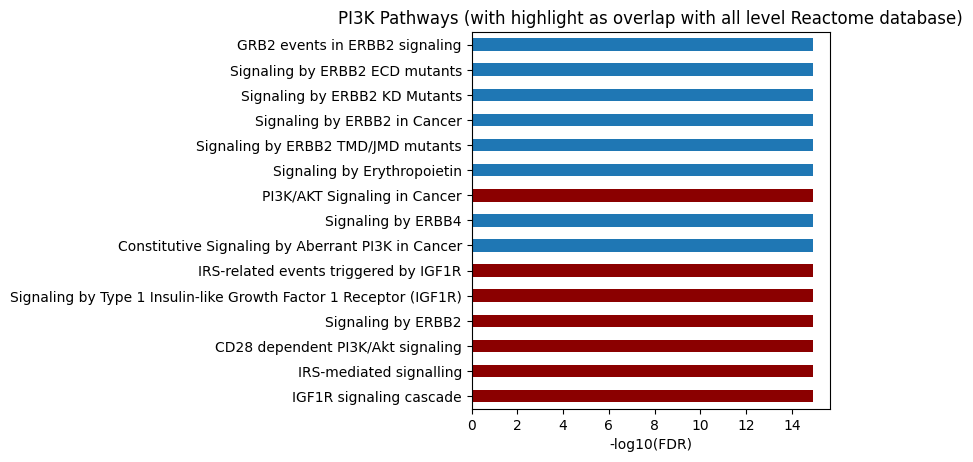

In [ ]:
# All level, use ref_col
plot_path(out,p_type='FDR',ref_col='ref_path',top_n=15)
plt.title('PI3K Pathways (with highlight as overlap with all level Reactome database)');

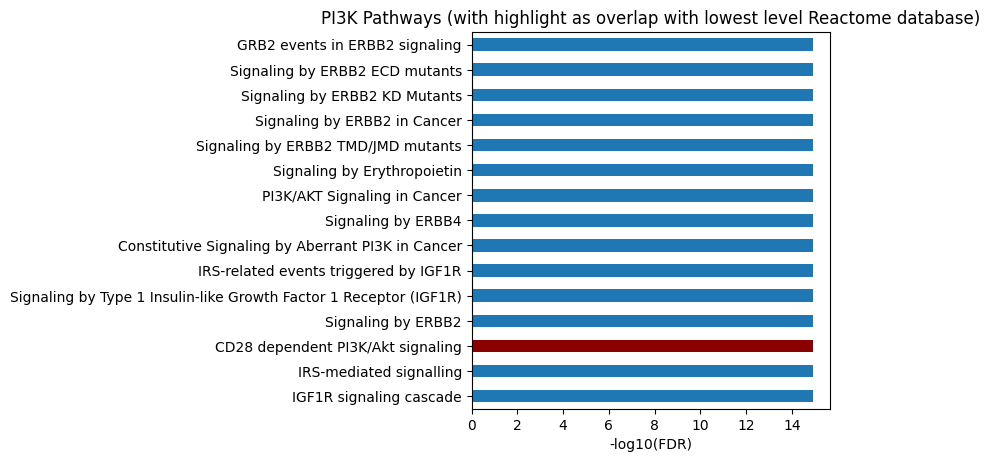

In [ ]:
# All level
plot_path(out,p_type='FDR',ref_col='ref_path_lowest',top_n=15)
plt.title('PI3K Pathways (with highlight as overlap with lowest level Reactome database)');

## Overlap

In [ ]:
#| export
def get_overlap(react_df, 
                 ref_id_list=None,
                 ref_col=None,  # column in react_df, 1 or 0 to indicate whether it's in ref
                 p_type='FDR',
                 thr=0.05,  # original threshold of p value, will be log10 transformed
                 plot=True,
                 figsize=(5,3),
                 **kwargs
                ):
    if p_type not in ['p', 'FDR']: raise ValueError("p_type must be either 'p' or 'FDR'")
    p_col = f'-log10_{p_type}'
    p_col_convert = p_col.replace('_', '(', 1) + ')'  # e.g., -log10(FDR)

    threshold = -np.log10(thr)

    # Subset based on input
    if ref_id_list is not None:
        subset = react_df[react_df.reactome_id.isin(ref_id_list)].copy()
    elif ref_col is not None:
        subset = react_df[react_df[ref_col] == 1].copy()
    else:
        raise ValueError("Need to give values to ref_id_list or ref_col")

    # Calculate and print statistics
    num_total = len(subset)
    num_pass = (subset[p_col] > threshold).sum()

    percent_pass = (num_pass / num_total) * 100 if num_total else 0

    # Plot histogram
    if plot:
        subset[p_col].hist(bins=100, figsize=figsize, **kwargs)
    
        # Add threshold line
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'{p_type} = {thr}')
        plt.legend()
    
        # Label axes
        plt.xlabel(p_col_convert)
    
        plt.text(0.66, 0.85, f'{percent_pass:.1f}% ({num_pass}/{num_total}) pass',
                 transform=plt.gca().transAxes,
                 ha='right', va='top', fontsize=10, color='green')

    return float(num_pass / num_total) if num_total else np.nan

0.8979591836734694

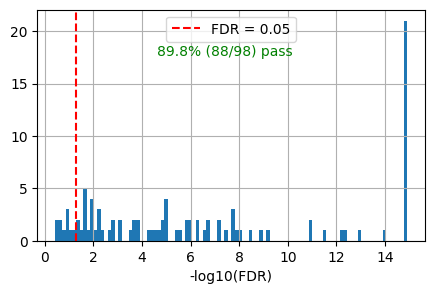

In [ ]:
get_overlap(out, ref_id_list=akt_path.reactome_id,plot=True)

0.8979591836734694

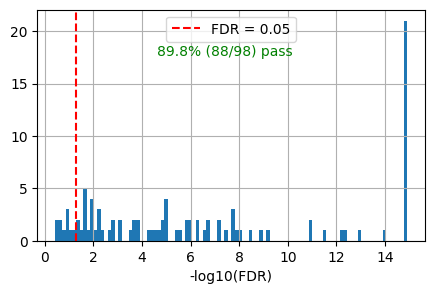

In [ ]:
get_overlap(out, ref_col='ref_path')

0.96875

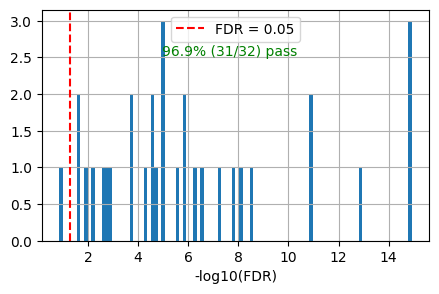

In [ ]:
get_overlap(out, ref_col='ref_path_lowest')

## Pipeline

```python
out = get_reactome(pi3ks,p_type='FDR')
out = add_reactome_ref(out,'P31749') # kinase uniprot
accuracy = get_overlap(out, ref_col='ref_path',plot=True) # if lowest, change all to lo
```

## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()